In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
file_path = 'E:/BCI_RL/important/ErrP/DMD/code/IncDMD/rawdata/'
sub = ['1', '2', '3', '4', '5', '6']
ses = ['1', '2']
file_name = file_path+'Subject0'+sub[2]+'_s'+ses[1]+'.mat'

In [3]:
runsdata = scipy.io.loadmat(file_name)['run']  
print(runsdata.shape)   # 1-10 blocks

# not total data
run = runsdata[0,0]   # 0,0 - 0,9
eeg = run[0,0]['eeg'].T
print(eeg.shape)

(1, 10)
(64, 91648)


In [4]:
header = run[0,0]['header']
SampleRate = header[0,0]['SampleRate'][0][0]   # 2D Array
print(SampleRate)

512


In [5]:
CLabel = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5','FC3','FC1',
           'C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3','P5','P7','P9',
           'PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2','AF8','AF4',
           'AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2','FCz','Cz',
           'C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4','P6','P8','P10','PO8','PO4','O2']

In [6]:
event = header[0,0]['EVENT']
POS = event[0,0]['POS']
TYP = event[0,0]['TYP']
pos = np.array([i[0] for i in POS]).reshape(len(POS), -1)
typ = np.array([i[0] for i in TYP]).reshape(len(TYP), -1)
print(pos.shape)

(67, 1)


In [7]:
# preprocess EEG data based on mne
# create events ndarray
EventArray = np.concatenate((pos, np.zeros([len(pos),1]), typ), axis=1)
EventArray = EventArray.astype(int)
print(EventArray.dtype)
print(EventArray.shape)
print(np.issubdtype(EventArray.dtype, np.integer))

int32
(67, 3)
True


In [8]:
# creating Raw object
info = mne.create_info(ch_names=CLabel, ch_types='eeg', sfreq=SampleRate)
raw = mne.io.RawArray(eeg, info)
print(len(raw.times))

Creating RawArray with float64 data, n_channels=64, n_times=91648
    Range : 0 ... 91647 =      0.000 ...   178.998 secs
Ready.
91648


In [9]:
# adding events
# infoevent = mne.create_info(['STI'], raw.info['sfreq'], ['stim'])
# stim_raw = mne.io.RawArray(np.zeros((1,len(raw.times))),infoevent)
# raw.add_channels([stim_raw], force_update_info=True)
# print(raw)
# raw.add_events(EventArray, stim_channel='STI')
# print(raw)

In [10]:
montage = mne.channels.make_standard_montage('biosemi64')
raw = raw.set_montage(montage, on_missing = 'raise', verbose = None)

In [11]:
# 数据预处理前降采样
raw, EventArray = raw.resample(200, events=EventArray)
print(EventArray.dtype)
print(EventArray.shape)
print(np.issubdtype(EventArray.dtype, np.integer))

int32
(67, 3)
True


In [12]:
# 重参考---50HZ工频陷波滤波---0-10Hz低通滤波---分段
raw = raw.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Effective window size : 10.240 (s)


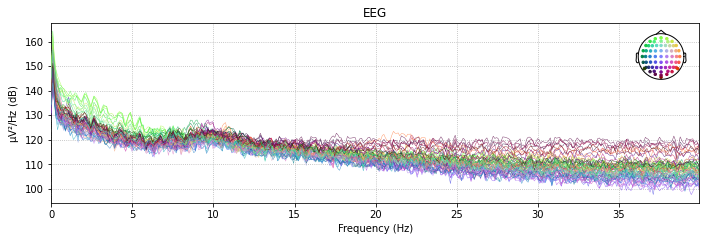

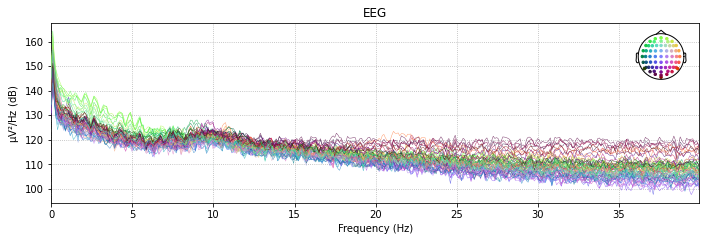

In [13]:
# raw.notch_filter(np.arange(60,241,60))  #  电力线噪音，数据在50Hz、150Hz、200Hz和250Hz存在窄频率峰值
raw.plot_psd(fmin=0, fmax=40)

In [14]:
# raw = raw.notch_filter(np.arange(50,251,50))
# raw.plot_psd(fmin=0, fmax=40)

In [15]:
# FIR滤波器参数: refer to function pop_eegfiltnew() in eeglab
# import math

# srate = 100
# fNyquist  = srate/2
# locut, hicut = 1, 20
# edgeArray = [locut, hicut]
# # Max stop-band width
# maxTBWArray = [locut, hicut]
# maxTBWArray[-1] = fNyquist - edgeArray[-1]
# maxDf = min(maxTBWArray)

# # Transition band width and filter order
# df = min([max([edgeArray[0] * 0.25, 2]),maxDf])
# filtorder = 3.3 / (df / srate)
# filtorder = math.ceil(filtorder / 2) * 2
# filtlength = filtorder + 1

# # Passband edge to cutoff (transition band center; -6 dB)
# cutoffArray = [edgeArray[0]-df/2, edgeArray[1]+df/2]
# print(cutoffArray)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 661 samples (3.305 sec)

Effective window size : 10.240 (s)


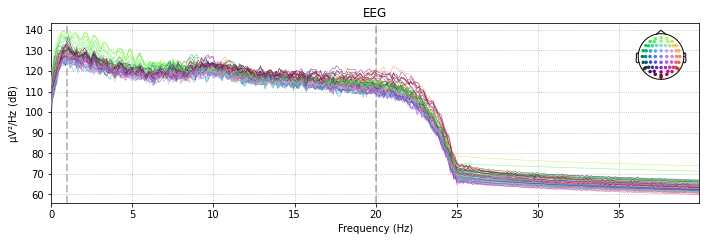

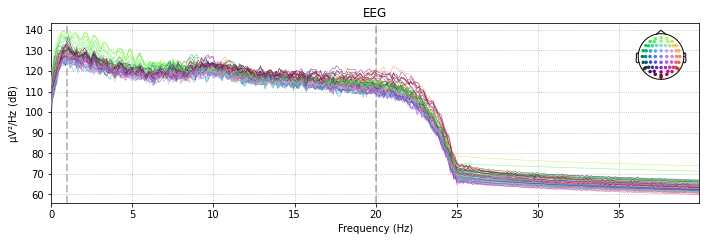

In [16]:
# raw = raw.filter(l_freq=locut, h_freq=hicut, filter_length=filtlength*2,l_trans_bandwidth=cutoffArray[0], h_trans_bandwidth=cutoffArray[1], fir_design='firwin')
raw = raw.filter(1,20.,fir_design='firwin')
raw.plot_psd(fmin=0, fmax=40)

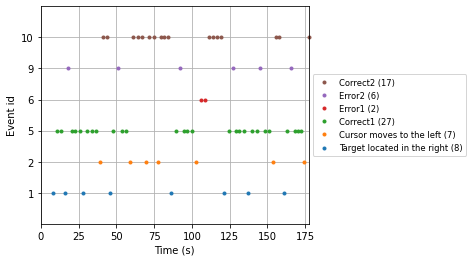

In [17]:
EventDict = {'Correct1':5, 'Correct2':10, 'Error1':6, 'Error2':9,
             'Target located in the right':1, 'Cursor moves to the left':2}
# Events = mne.find_events(raw, stim_channel='STI')
event_fig = mne.viz.plot_events(EventArray, event_id=EventDict, sfreq=raw.info['sfreq'])
event_fig.subplots_adjust(right=0.7)  # make room for the legend

In [18]:
# epoch the desired eeg data and remove baseline
EpochCorrect = {'Correct1':5, 'Correct2':10}
EpochError = {'Error1':6, 'Error2':9}
epochsCorrect = mne.Epochs(raw, np.array(EventArray), event_id=EpochCorrect, tmin=-0.2, 
                    tmax=0.8, baseline=(-0.2,0))
print(epochsCorrect)
epochsError = mne.Epochs(raw, np.array(EventArray), event_id=EpochError, tmin=-0.2, 
                    tmax=0.8, baseline=(-0.2,0))
print(epochsError)

Not setting metadata
Not setting metadata
44 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  44 events (good & bad), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~91 kB, data not loaded,
 'Correct1': 27
 'Correct2': 17>
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  8 events (good & bad), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~91 kB, data not loaded,
 'Error1': 2
 'Error2': 6>


In [19]:
# Decimate the Epochs object using mne.Epochs.decimate() or the decim argument to the mne.Epochs object
# epochsCorrect = epochsCorrect.decimate(5)
# epochsError = epochsError.decimate(5)

In [20]:
epochsCorrect = epochsCorrect.load_data()
epochsError = epochsError.load_data()
# epochsCorrect.resample(newSampleRate)
# epochsError.resample(newSampleRate)

correctdata = epochsCorrect.get_data('eeg')
correcttimes = epochsCorrect.times
errordata = epochsError.get_data('eeg')
errortimes = epochsError.times
print(errordata.shape)

Loading data for 44 events and 201 original time points ...
0 bad epochs dropped
Loading data for 8 events and 201 original time points ...
0 bad epochs dropped
(8, 64, 201)


[47, 37, 46]


Text(0, 0.5, 'Channel FCz')

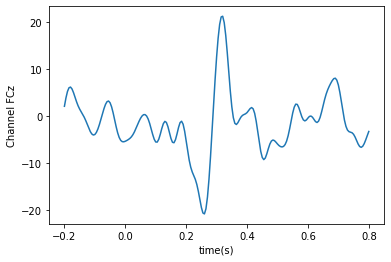

In [21]:
chan_index = [CLabel.index('Cz'), CLabel.index('Fz'), CLabel.index('FCz')]
print(chan_index)
plt.plot(errortimes, errordata[3][chan_index[2]])
plt.xlabel('time(s)')
plt.ylabel('Channel '+CLabel[chan_index[2]])

In [22]:
# 首先构造一个trial的特征向量
import math

trial = errordata[3]  # nchannel * time points

# EEG stack
m = trial.shape[0]  # 行
n = trial.shape[1]  # 列
nstack = math.ceil(n*2 / (m+2))

aug_trial = np.array(trial[:,0:n-nstack+0+1])
for st in range(1, nstack):
    aug_trial = np.vstack((aug_trial, trial[:,st:n-nstack+st+1]))
print(nstack)
print(aug_trial.shape)

7
(448, 195)


In [23]:
# DMD for feature vector
from pydmd import DMD

dmd = DMD(svd_rank=0, exact=True)    
# dmd_optb = DMD(svd_rank=0, exact=True, opt=True), 可能opt方法这里有什么要求

dmd.fit(aug_trial)
# dmd_optb.fit(aug_trial)

D:\Anaconda\envs\pytorch\lib\site-packages\pydmd\dmdbase.py:351: UserWarning: Input data matrix X has condition number 4520520.568398088. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  cond_number


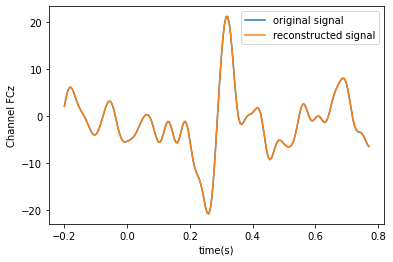

In [24]:
# DMD property
recon_trial = dmd.reconstructed_data

plt.plot(errortimes[0:len(aug_trial[0])], aug_trial[chan_index[2]], label='original signal')
plt.plot(errortimes[0:len(aug_trial[0])], recon_trial[chan_index[2]].real, label='reconstructed signal')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('Channel '+CLabel[chan_index[2]])
plt.show()

In [25]:
# dt不对，导致f显示不对，但其实对重构数据没有影响
# np.log(self.eigs).imag / (2 * np.pi * self.original_time["dt"])
dt = 1 / 200
dmd_f = dmd.frequency / dt
dmd_phi = dmd.modes
dmd_dynamic = dmd.dynamics
dmd_b = dmd.amplitudes

print(dmd_f) 

[ 55.38945668 -55.38945668  49.28685637 -49.28685637  45.26686785
 -45.26686785  40.00848893 -40.00848893  38.24458464 -38.24458464
  35.38441109 -35.38441109  34.20994057 -34.20994057  31.86917558
 -31.86917558  30.05030406 -30.05030406  28.56306631 -28.56306631
  26.29230003 -26.29230003  24.37311121 -24.37311121  23.82242295
 -23.82242295  23.27702919 -23.27702919  22.41972226 -22.41972226
  21.64642089 -21.64642089  20.73176242 -20.73176242  19.75170891
 -19.75170891  19.75888447 -19.75888447  18.59287944 -18.59287944
  17.25107688 -17.25107688  16.37280518 -16.37280518  16.1581478
 -16.1581478   15.05846875 -15.05846875  14.14477996 -14.14477996
   0.          12.78404566 -12.78404566  11.84833118 -11.84833118
  10.92787435 -10.92787435  10.4120613  -10.4120613    9.33828739
  -9.33828739   8.42426894  -8.42426894   0.29183767  -0.29183767
   1.34396977  -1.34396977   2.43969614  -2.43969614   3.64303131
  -3.64303131   4.32564485  -4.32564485   5.55280189  -5.55280189
   7.430651

In [26]:
# 那应该就是eeglab和mne实现的滤波器不一样，导致DMD拟合结果不一致。感觉也问题不大。
idx = [i for i in range(len(dmd_f)) if abs(dmd_f[i])>2 and abs(dmd_f[i])<12]
print(idx)

[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78]


In [27]:
b = dmd_b[idx]
phi = dmd_phi[:, idx]
dynamic = dmd_dynamic[idx, :]
print(dmd_dynamic.shape)
print(dmd_b.shape)

recon_freq = phi.dot(dynamic)
print(recon_freq.shape)

(79, 195)
(79,)
(448, 195)


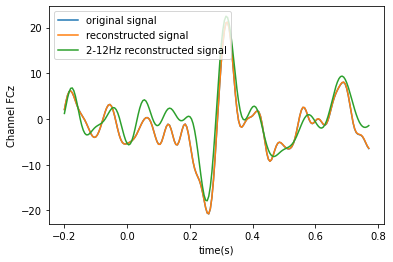

In [28]:
plt.plot(errortimes[0:len(aug_trial[0])], aug_trial[chan_index[2]], label='original signal')
plt.plot(errortimes[0:len(aug_trial[0])], recon_trial[chan_index[2]].real, label='reconstructed signal')
plt.plot(errortimes[0:len(aug_trial[0])], recon_freq[chan_index[2]].real, label='2-12Hz reconstructed signal')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('Channel '+CLabel[chan_index[2]])
plt.show()

In [30]:
# 某一通道处的模态相位分析
# 乘以不乘以b？
cmp = np.empty(shape=(len(idx),len(dynamic[0])), dtype=complex)
for i in range(len(idx)):
    cmp[i, :] = phi[chan_index[2]][i] * dynamic[i, :]
# angle
ang = np.angle(cmp)
print(ang.shape)
# Euler's formular
expang = np.exp(1.0j * ang)
print(expang.shape)
# variance of complex vector
varvec = np.var(expang, axis=0)
print(varvec.shape)
print(varvec)
# angvar = np.angle(varvec)
# print(angvar)

(22, 195)
(22, 195)
(195,)
[0.99441122 0.99386561 0.99319323 0.99256959 0.99217603 0.99215538
 0.99257312 0.99340211 0.9945361  0.99582335 0.99710473 0.99824292
 0.99913702 0.99972549 0.99998495 0.99993221 0.99963234 0.99920736
 0.99883207 0.99869832 0.99893394 0.99948083 0.9999676  0.99964309
 0.9974489  0.99228254 0.98343107 0.97105885 0.95655126 0.94250205
 0.93221607 0.92877382 0.93391189 0.94712179 0.96537501 0.98370885
 0.99659864 0.99971225 0.99143519 0.97357622 0.95093191 0.92981069
 0.91602444 0.91307409 0.92118422 0.93750497 0.95733767 0.97585239
 0.98961395 0.99737377 0.99994049 0.99934065 0.99774149 0.99662542
 0.99649944 0.99711743 0.99795266 0.99859603 0.99888176 0.99876125
 0.99811743 0.99673251 0.99448454 0.99164656 0.98903471 0.98779617
 0.98883861 0.99216339 0.99651011 0.99963413 0.99923032 0.99413345
 0.98518441 0.97521855 0.96802197 0.96664269 0.97185563 0.98161218
 0.99188422 0.998606   0.99977462 0.99655336 0.99261268 0.9918167
 0.99531502 0.99962818 0.99706854 0.

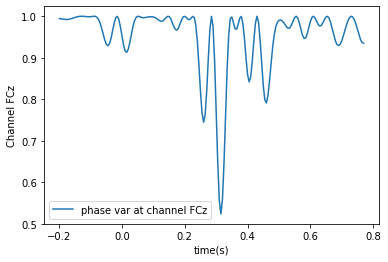

In [31]:
plt.plot(errortimes[0:len(aug_trial[0])], varvec, label='phase var at channel FCz')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('Channel '+CLabel[chan_index[2]])
plt.show()

In [32]:
meanvec = np.sum(expang, axis=0)
print(sumvec.shape)
meanvec = np.angle(sumvec)

NameError: name 'sumvec' is not defined

D:\Anaconda\envs\pytorch\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


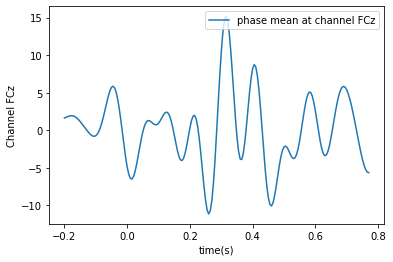

In [33]:
plt.plot(errortimes[0:len(aug_trial[0])], meanvec, label='phase mean at channel FCz')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('Channel '+CLabel[chan_index[2]])
plt.show()

In [34]:
#ITPC
itpc = abs(np.mean(expang, axis=0))
print(itpc.shape)

(195,)


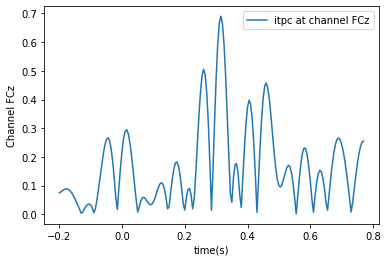

In [35]:
plt.plot(errortimes[0:len(aug_trial[0])], itpc, label='itpc at channel FCz')
plt.legend()
plt.xlabel('time(s)')
plt.ylabel('Channel '+CLabel[chan_index[2]])
plt.show()